<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [2]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.55


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=cbbfd639f55f742878c580580c62403a&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbk5pRDdvcDRvdS05S25vZDZUWVpNWjZ4dUQ2RG5idWtQX1AzdmNhNEY2bHVFZ3B4RXFUWkY4R1NuU3MyaEtKUSIsInN0YXRlIjoiY2JiZmQ2MzlmNTVmNzQyODc4YzU4MDU4MGM2MjQwM2EifQ==


In [4]:
# https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
# Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table

File downloaded:

• 2023_11_01FIA_soil_subset.csv <id: 17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [5]:
# https://drive.google.com/file/d/1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ/view?usp=drive_link
drive_download(as_id('1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ'), path = "/content/250_summary_grid_dt.gpkg", overwrite = TRUE)
grid_dt <- st_read("/content/250_summary_grid_dt.gpkg") %>% st_transform(4326) %>% data.table()

File downloaded:

• 250_summary_grid_full_dt.gpkg <id: 1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ>

Saved locally as:

• /content/250_summary_grid_dt.gpkg



Reading layer `250_summary_grid_full_dt' from data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Simple feature collection with 227561 features and 35 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 16952.32 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


In [ ]:
print('hello')

In [20]:
# Simulation data
# https://drive.google.com/file/d/1HsEZDWJN7XO4aOZlMwbr_6MN3_-xUV81/view?usp=drive_link Run 1
drive_download(file = as_id('1HsEZDWJN7XO4aOZlMwbr_6MN3_-xUV81'), path =  '/content/sim_results_Hawaii_Run1.gpkg', overwrite = TRUE)

# https://drive.google.com/file/d/15tK1_k9FEGda5aL0P9SyRID-Xk0p_YuF/view?usp=drive_link Run 2
drive_download(file = as_id('15tK1_k9FEGda5aL0P9SyRID-Xk0p_YuF'), path =  '/content/sim_results_Hawaii_Run2.gpkg', overwrite = TRUE)

# https://drive.google.com/file/d/1RrfNnsmy5ec0inSq35m_uEF3eskgcDDB/view?usp=drive_link Run 3
drive_download(file = as_id('1RrfNnsmy5ec0inSq35m_uEF3eskgcDDB'), path =  '/content/sim_results_Hawaii_Run3.gpkg', overwrite = TRUE)


File downloaded:

• sim_results_Hawaii_10000m_Run1.gpkg <id: 1HsEZDWJN7XO4aOZlMwbr_6MN3_-xUV81>

Saved locally as:

• /content/sim_results_Hawaii_Run1.gpkg

File downloaded:

• sim_results_Hawaii_10000m_Run2.gpkg <id: 15tK1_k9FEGda5aL0P9SyRID-Xk0p_YuF>

Saved locally as:

• /content/sim_results_Hawaii_Run2.gpkg

File downloaded:

• sim_results_Hawaii_10000m_Run3.gpkg <id: 1RrfNnsmy5ec0inSq35m_uEF3eskgcDDB>

Saved locally as:

• /content/sim_results_Hawaii_Run3.gpkg



In [22]:
sim_dt <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4531526,242.1,62562648,3341.3,78203310,4176.6
Vcells,17718360,135.2,1566773407,11953.6,1487682105,11350.2


In [23]:
sim_1_dt <- st_read( '/content/sim_results_Hawaii_Run1.gpkg') %>% data.table
sim_2_dt <- st_read( '/content/sim_results_Hawaii_Run2.gpkg') %>% data.table
sim_3_dt <- st_read( '/content/sim_results_Hawaii_Run3.gpkg') %>% data.table

Reading layer `sim_results_Hawaii_10000m_Run1' from data source 
  `/content/sim_results_Hawaii_Run1.gpkg' using driver `GPKG'
Simple feature collection with 5600000 features and 74 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -156.0017 ymin: 19.0045 xmax: -154.8362 ymax: 20.25088
Geodetic CRS:  WGS 84
Reading layer `sim_results_Hawaii_10000m_Run2' from data source 
  `/content/sim_results_Hawaii_Run2.gpkg' using driver `GPKG'
Simple feature collection with 5600000 features and 74 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -156.0017 ymin: 19.0045 xmax: -154.8362 ymax: 20.25088
Geodetic CRS:  WGS 84
Reading layer `sim_results_Hawaii_10000m_Run3' from data source 
  `/content/sim_results_Hawaii_Run3.gpkg' using driver `GPKG'
Simple feature collection with 5600000 features and 74 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -156.0017 ymin: 19.0045 xmax: -154.8362 ymax: 20.25088
Geodetic CRS:  WGS 84


In [24]:
sim_dt <-list(sim_1_dt,sim_2_dt,sim_3_dt) %>% rbindlist()

In [8]:
grid_int_dt  <- fia_dt$geom %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt$geom)

In [9]:
rm_vec <- grid_int_dt %>% lapply(length) %>% unlist > 0
grid_int_dt <- grid_int_dt[rm_vec]
fia_dt <- fia_dt[rm_vec,]

In [10]:
grid_dt <- grid_dt[!is.na(srad),]

In [11]:
grid_dt$agbd_n <- grid_dt$agbd_n %>% as.numeric

In [12]:
fia_dt$Stock_SOC_Mg_Ha <- fia_dt$Stock_SOC_Mg_Ha %>% as.numeric

Warning message in fia_dt$Stock_SOC_Mg_Ha %>% as.numeric:
“NAs introduced by coercion”


In [25]:
sim_dt %>% nrow

[1] 16800000

In [26]:
sim_dt[,z:=(predicted-Stock_SOC_Mg_Ha)/Stock_SOC_Mg_Ha]

In [27]:
sim_dt[,residual_per:=(predicted-Stock_SOC_Mg_Ha)/Stock_SOC_Mg_Ha]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


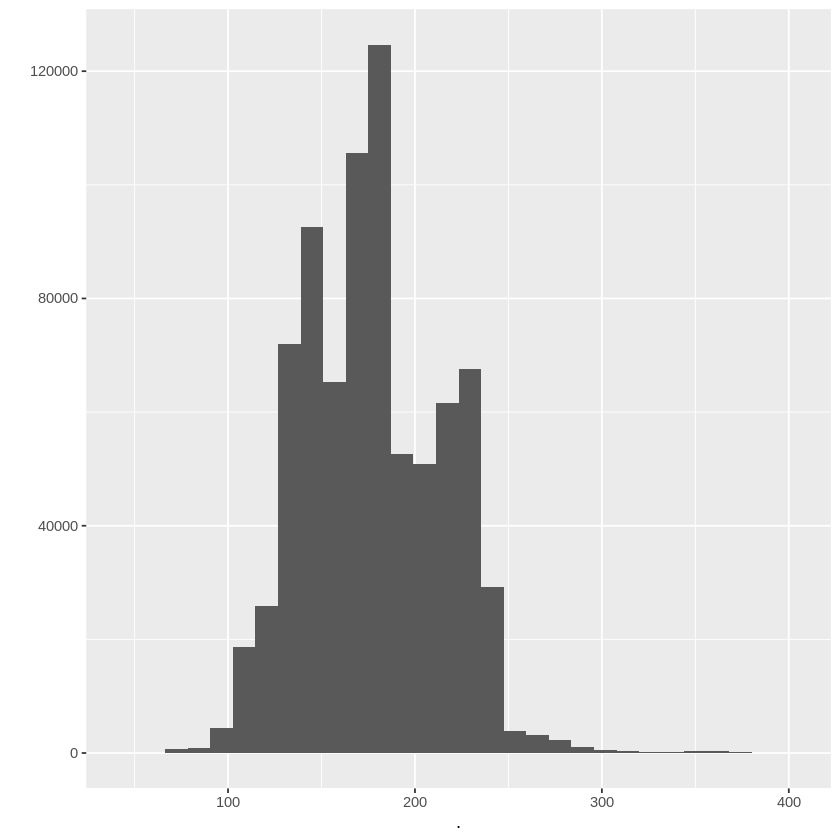

In [31]:
sim_dt[ z > -0.05 &z<0.05]$predicted %>% qplot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


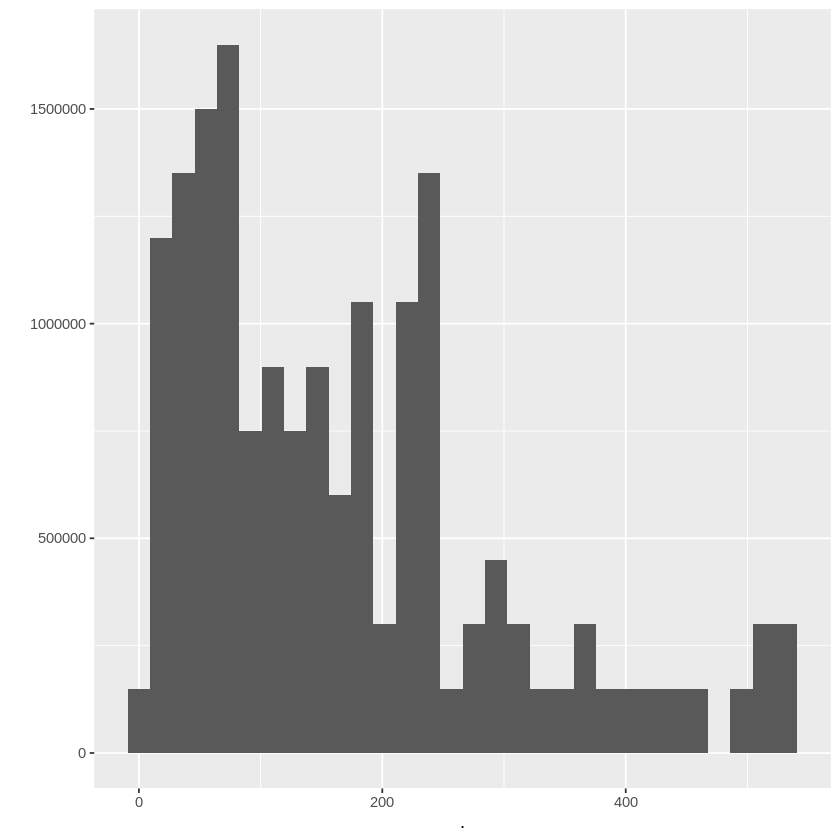

In [30]:
sim_dt$Stock_SOC_Mg_Ha %>% qplot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


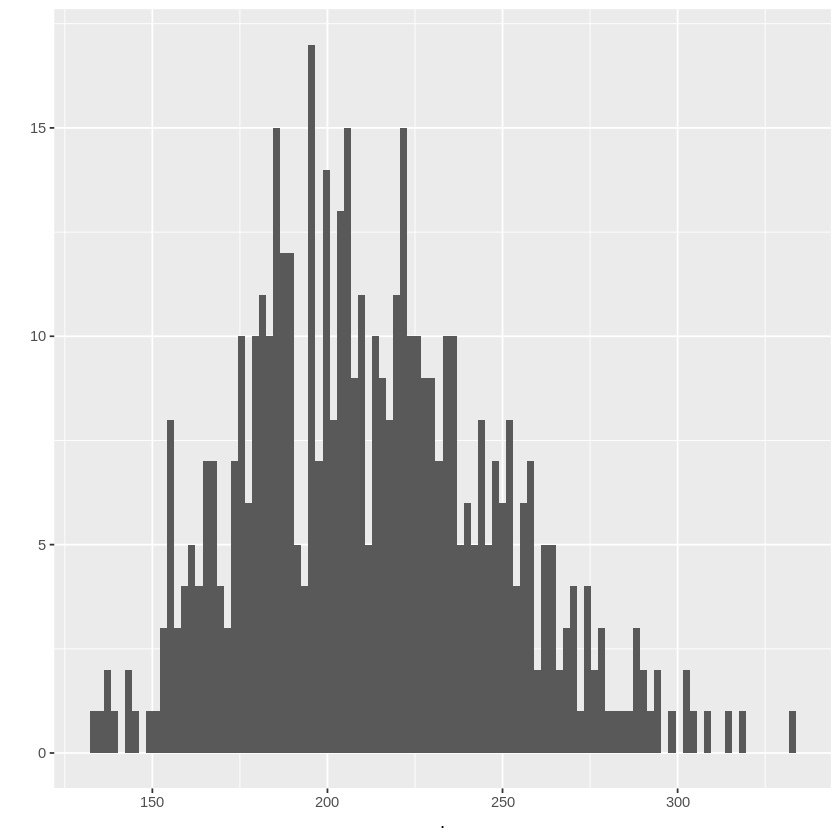

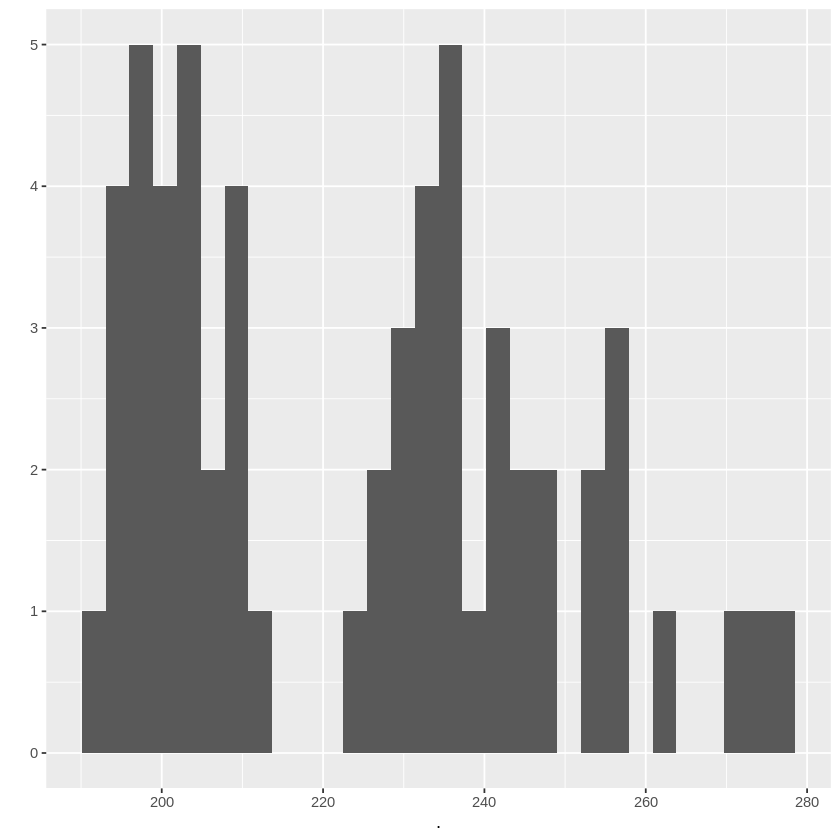

In [28]:
sim_dt[id==2831164]$predicted %>% qplot(bins=100)

sim_dt[id==2831164 & z > -0.05 &z<0.05]$predicted %>% qplot(geom='histogram')

In [32]:
sim_summary_dt <- sim_dt[,list(length = length(r2),length_05 = length(r2[sqrt((z)^2) <0.05]),geom=unique(geom)),by=.(id,PLOT)]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


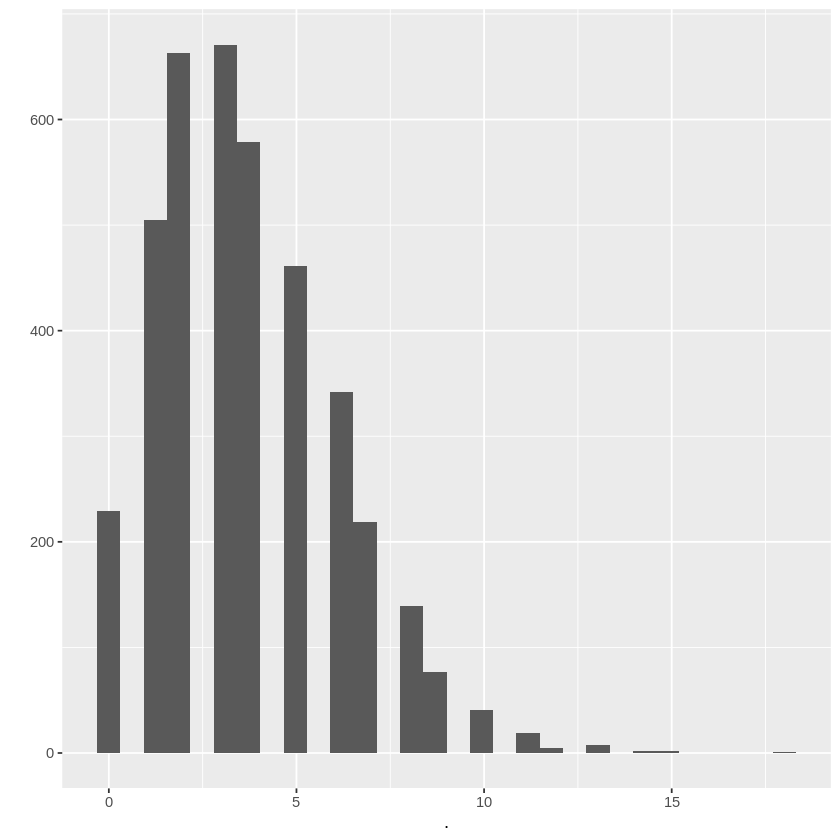

In [33]:
# sim_summary_dt
sim_summary_dt[PLOT==5289]$length_05 %>% qplot

In [18]:
sim_summary_dt %>% st_as_sf %>% st_write('sim_summary_id_plot.gpkg',delete_dsn = T)

writing: substituting ENGCRS["Undefined Cartesian SRS with unknown unit"] for missing CRS



Deleting source `sim_summary_id_plot.gpkg' failed
Writing layer `sim_summary_id_plot' to data source 
  `sim_summary_id_plot.gpkg' using driver `GPKG'
Writing 277038 features with 4 fields and geometry type Point.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


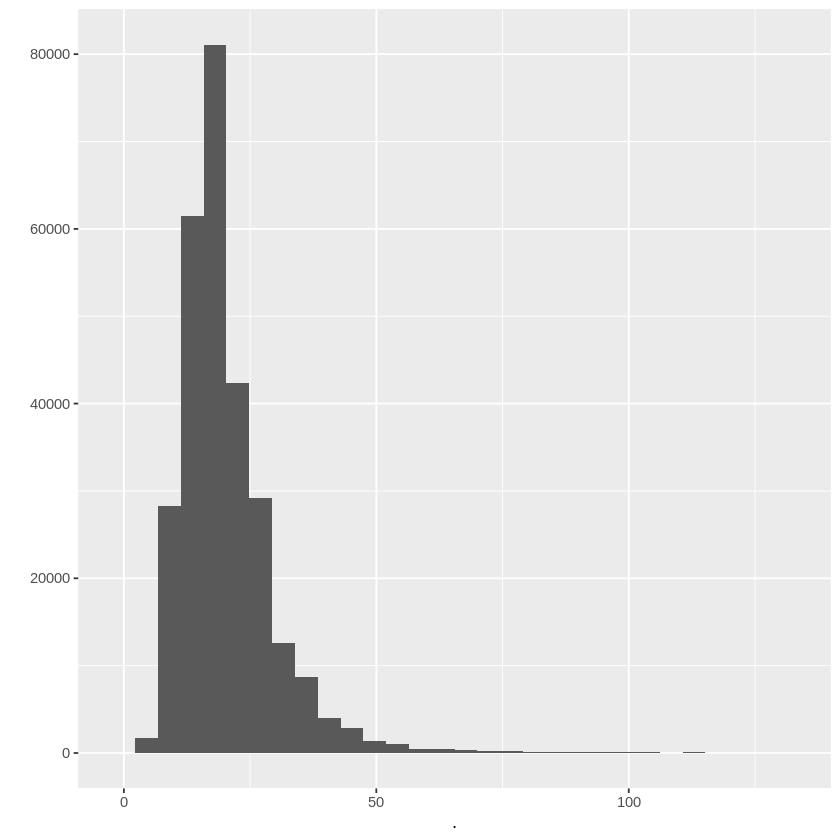

In [19]:
sim_summary_dt$length %>% qplot

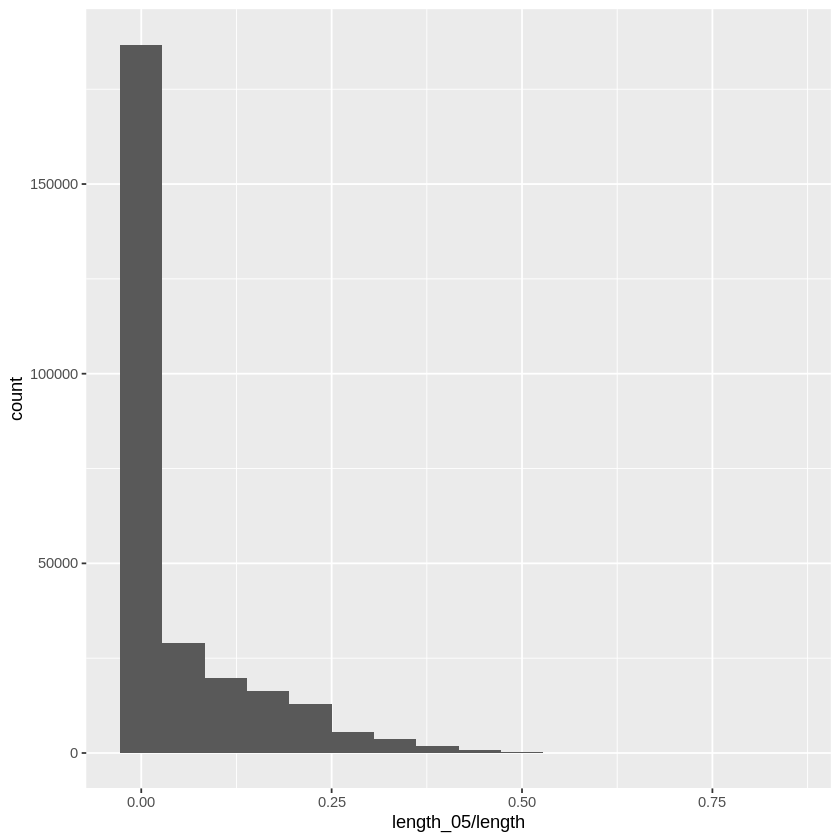

In [20]:
sim_summary_dt %>%
  ggplot(aes(x= length_05/length)) +
  geom_histogram(bins=16)
    # geom_smooth(method = 'lm')

In [21]:
sim_summary_dt[max(length_05/length)*.8 < length_05/length][order(length_05/length)]

id,PLOT,length,length_05,geom
<dbl>,<chr>,<int>,<int>,<list>
2804195,2394,7,5,"-155.34813, 19.80626"
2699266,2768,7,5,"-155.51510, 19.17169"
2693239,5059,18,13,"-155.52462, 19.20557"
2880861,2394,11,8,"-155.22649, 19.77675"
2844718,2312,8,6,"-155.28353, 19.93718"
2921526,2490,8,6,"-155.16247, 19.58694"
2859826,2394,4,3,"-155.25991, 19.76099"
2871842,2364,9,7,"-155.24080, 19.77903"
2885363,2394,6,5,"-155.21930, 19.79255"


In [22]:
names(sim_dt)[39:68]

[1] "age_years"                  "age_class"                 
 [3] "predicted"                  "var_imp_water"             
 [5] "var_imp_trees"              "var_imp_grass"             
 [7] "var_imp_flooded_vegetation" "var_imp_crops"             
 [9] "var_imp_shrub_and_scrub"    "var_imp_built"             
[11] "var_imp_bare"               "var_imp_snow_and_ice"      
[13] "var_imp_elevation"          "var_imp_landform"          
[15] "var_imp_SRTM_mTPI"          "var_imp_aet"               
[17] "var_imp_def"                "var_imp_pdsi"              
[19] "var_imp_pet"                "var_imp_pr"                
[21] "var_imp_ro"                 "var_imp_soil"              
[23] "var_imp_srad"               "var_imp_swe"               
[25] "var_imp_tmmn"               "var_imp_tmmx"              
[27] "var_imp_vap"                "var_imp_vpd"               
[29] "var_imp_vs"                 "var_imp_agbd_m"

In [23]:
sim_dt[,good:=abs(residual_per) < 0.1]

In [24]:
# sim_dt$id %>% table

In [25]:
names(sim_dt)[39:68] %>% lapply(function(x){
t.test(sim_dt[id ==2957662  & abs(residual_per) < 0.5 ][[x]],
sim_dt[id ==2957662  & abs(residual_per) >= 0.5 ][[x]])$p.value})


ERROR: ignored

In [ ]:
(sim_dt %>% names)[40:69]

In [40]:
sim_dt$id %>% sample(1)
sim_dt[id==2762315]$PLOT %>% table

[1] 2840264

.
2672 2678 2702 4158 5059 5450 5553 
  86  120   60  209   64   82   89 

In [39]:
sim_dt[id==2762315] %>% nrow

[1] 710

In [48]:
#  sim_dt[id==2762315 &PLOT == 2678]$z %>% abs %>% qplot

In [59]:
x <- sim_dt[id==2762315 &PLOT == 2678 ]$var_imp_grass
z <- sim_dt[id==2762315 &PLOT == 2678 ]$z

if(length(x[abs(z) < 0.05])>3 &length(x[abs(z) >= 0.05])>3 ){
  t.test(x[abs(z) < 0.05],
          x[abs(z) >= 0.05])$p.value
          }else(return(NA))

[1] 0.2504314

In [62]:
 var_imp_dt<- sim_dt[ ][
  , .(p_value = lapply(.SD, function(x) {
    if(length(x[abs(z) < 0.05])>3 &length(x[abs(z) >= 0.05])>3 ){
      t.test(x[abs(z) < 0.05],
             x[abs(z) >= 0.05])$p.value
             }else(return(NA))

    }) ,
      variable = names(sim_dt)[42:73])
  , by = .(id,PLOT)
  , .SDcols = 42:73
]

var_imp_dt$p_value <- var_imp_dt$p_value %>% unlist

In [61]:
var_imp_dt

id,PLOT,p_value,variable
<dbl>,<chr>,<dbl>,<chr>
2762315,2678,0.54546297,var_imp_water
2762315,2678,0.04534548,var_imp_trees
2762315,2678,0.25043140,var_imp_grass
2762315,2678,0.52329353,var_imp_flooded_vegetation
2762315,2678,0.89326437,var_imp_crops
2762315,2678,0.05401863,var_imp_shrub_and_scrub
2762315,2678,0.17380199,var_imp_built
2762315,2678,0.08250781,var_imp_bare
2762315,2678,0.99867462,var_imp_snow_and_ice


In [63]:
grid_dt %>% names

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "water"             
 [7] "trees"              "grass"              "flooded_vegetation"
[10] "crops"              "shrub_and_scrub"    "built"             
[13] "bare"               "snow_and_ice"       "max"               
[16] "elevation"          "landform"           "SRTM_mTPI"         
[19] "aet"                "def"                "pdsi"              
[22] "pet"                "pr"                 "ro"                
[25] "soil"               "srad"               "swe"               
[28] "tmmn"               "tmmx"               "vap"               
[31] "vpd"                "vs"                 "agbd_m"            
[34] "agbd_sd"            "agbd_n"             "geom"

In [64]:
# out_dt <- data.table(var_imp_dt,sim_summary_dt[match(var_imp_dt$id,sim_summary_dt$id)])
out_dt <- data.table(var_imp_dt,grid_dt[,c('geom')][match(var_imp_dt$id,grid_dt$id)])

In [65]:
out_dt[,bonferroni:=p_value*30]

In [66]:
out_dt$p_value <- out_dt$p_value %>% unlist

In [89]:
out_dt[PLOT==4791 &p_value <0.2][,list(p_value = mean(p_value)),by=variable]

variable,p_value
<chr>,<dbl>
var_imp_water,0.06861381
var_imp_trees,0.10117101
var_imp_grass,0.07374218
var_imp_flooded_vegetation,0.09279270
var_imp_built,0.07514061
var_imp_bare,0.07954694
var_imp_elevation,0.07304669
var_imp_pdsi,0.09252228
var_imp_pr,0.06615926


In [79]:
# short_out_dt[!is.na(var_imp_aet),]

In [81]:
short_out_dt <- dcast(out_dt, id  + PLOT~ variable,value.var='bonferroni', drop=FALSE)
short_out_dt <-short_out_dt[!is.na(var_imp_aet),]

In [102]:
good_set <- out_dt[,list(bonferroni_20 = mean(bonferroni[bonferroni<.2],na.rm=T),n=length(bonferroni[bonferroni<.05])),by = .(PLOT,variable)][!is.na(bonferroni_20)]$PLOT %>% unique

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


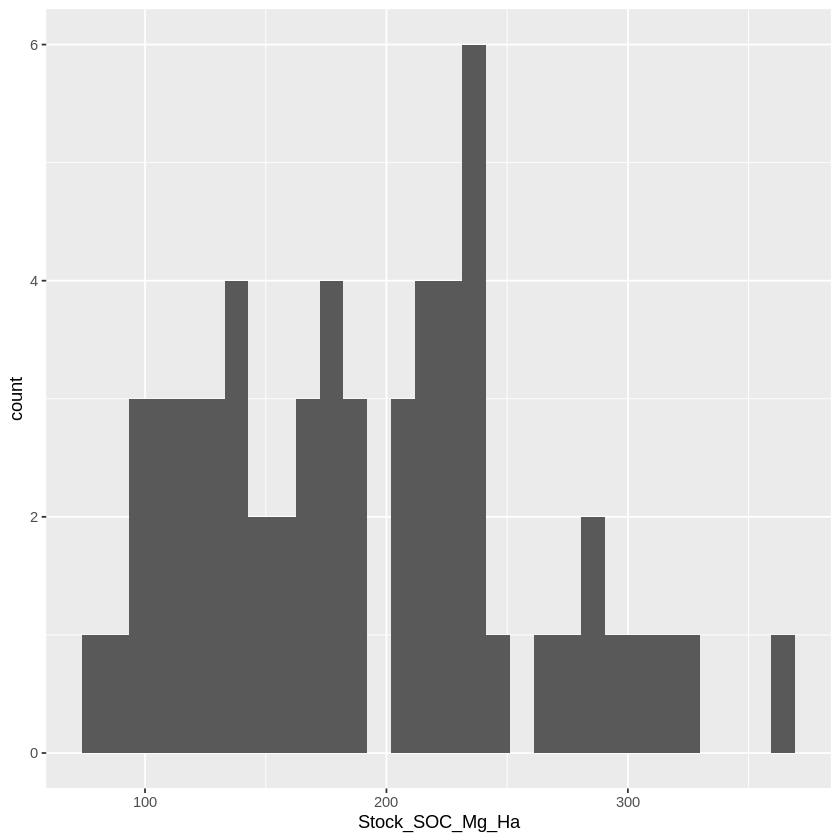

In [104]:
fia_dt[PLOT %in% good_set] %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha))+
  geom_histogram()

In [106]:
fia_dt[PLOT %in% good_set]$Stock_SOC_Mg_Ha %>% mean(na.rm=T)

[1] 190.2822

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


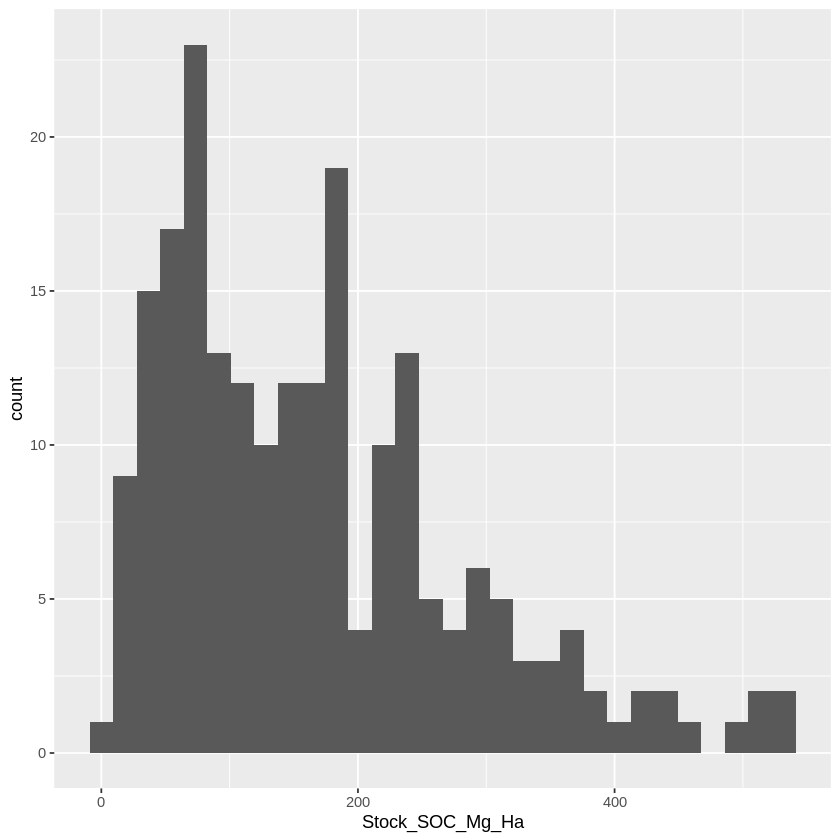

In [103]:
fia_dt %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha))+
  geom_histogram()

In [82]:
short_out_dt <- data.table(short_out_dt,grid_dt[,c('geom')][match(short_out_dt$id,grid_dt$id)])

In [85]:
short_out_dt %>% st_as_sf %>% st_write('bonferroni_adj.gpkg')

Writing layer `bonferroni_adj' to data source 
  `bonferroni_adj.gpkg' using driver `GPKG'
Writing 75343 features with 34 fields and geometry type Point.


In [ ]:
cols_to_consider <- names(short_out_dt)[]


# Assuming 'short_out_dt' is your data.table
# Define the columns you want to consider for finding the max value by their indices
cols_to_consider_indices <- 3:(ncol(short_out_dt)-1) # Replace with actual indices of Var3, Var5, Var7
short_out_dt$max_col <-
1:nrow(short_out_dt) %>% lapply(function(x){
if(is.na(short_out_dt[x,cols_to_consider_indices,with=F] %>% unlist) %>% all){return(NA)}
short_out_dt[x,cols_to_consider_indices,with=F] %>% unlist %>% which.min( ) %>% names}) %>% unlist

In [ ]:
short_out_dt %>% st_write('max_col_p.gpkg')

In [ ]:
short_out_dt

In [ ]:
short_out_dt %>%
  ggplot(aes(x=1:nrow(short_out_dt),y=soil))+
  geom_line()

In [ ]:
out_dt[bonferroni <= .05]$variable %>% table

In [ ]:
out_dt[bonferroni<= 0.1] %>%
  ggplot(aes(x= variable %>% factor))+
  geom_bar()
  # geom_smooth(method='lm')

In [ ]:
data.table(out_dt) %>% st_as_sf() %>% st_write('/content/plot_sig_variables.gpkg',delete_dsn=T)

In [ ]:
# sim_dt[id ==2222069  ]
# 1850844
# sqrt(((Stock_SOC_Mg_Ha-predicted)/Stock_SOC_Mg_Ha)^2)<0.05
sim_dt[id ==2952969  & sqrt(((Stock_SOC_Mg_Ha-predicted)/Stock_SOC_Mg_Ha)^2)<0.05] %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha)) +
  geom_histogram()
  # print()

In [ ]:
sim_dt %>%
  ggplot(aes(y=Stock_SOC_Mg_Ha,x=r2))+
    geom_bin2d()
    # geom_smooth()

In [ ]:
# Load the necessary library
library(repr)

# Adjust width and height of plots
options(repr.plot.width=20, repr.plot.height=8)